# miDHM Object Reconstruction Numerical Algorithm


In [106]:
#%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageOps
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import scipy
from scipy.integrate import simps
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import unwrap_phase
from skimage import color, exposure
from tifffile import imread, imwrite
from skimage.transform import resize
#from phase_unwrap import phase_unwrap, _wrapToPi

#plt.style.use('dark_background')


#from phase_unwrap import *

In [111]:
# Load image into Python
def load_img(addpath):
    # Images with neutral density filter
    #addpath = "D://bets_images//01.03.23._20.02//01.03.23._20.19//02.24.23._16.18//"

    # Images with no neutral density filter
    # addpath = ('/Users/charlyk/Desktop/PhD/work/Images/04.21.23._22.18/No_ND/')

    # Load the RGB hologram image
    #img = Image.open(addpath+'frames_7.tif').convert("L")
    img = Image.open(addpath+'frame_614.tif')
    width, height = img.size
    
    ref = Image.open(addpath+'frame_70.tif')
    #ref=ImageOps.fit(ref, (1080,720), Image.Resampling.LANCZOS)
    

    # Convert the RGB image to grayscale
    # gray_image = rgb_image.convert("L")
    img = img.convert("L")
    ref = ref.convert("L")

    # Convert the image to a NumPy array
    img = np.asarray(img)/255                  # convert the images into array
    ref = np.asarray(ref)/255
    

    #plt.imshow(img)
    
    return img,ref

    

(990, 1332)

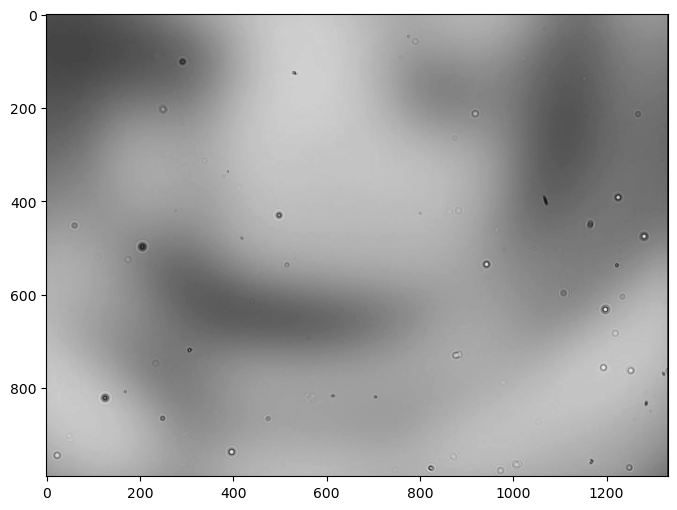

In [181]:
#%matplotlib tk
path="C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023//"
img,ref=load_img(path)
#img=(img>.72)
plt.imshow(img, cmap='gray')

img.shape

In [99]:
import cv2
path="C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023//frame_614.tif"
from PIL import Image, ImageDraw, ImageFont

# Open an image (replace 'image.jpg' with your image file)
image = Image.open(path)

# Initialize drawing context
draw = ImageDraw.Draw(image)

# Specify the font, size, and color
font = ImageFont.truetype('arial.ttf', size=15)  # You may need to provide a valid font file path
text_color = (200, 0, 0)  # RGB color for the text (red in this example)

# Specify the position to place the text

# The text to be added
text = ["1st","2nd","3rd"]
text_position=[(909,520),(469,415),(367,922)] # (x, y) coordinates

# Add the text to the image
for i in range(len(text)):
    draw.text(text_position[i], text[i], fill=text_color, font=font)

# Save or display the modified image
#image.save('2nd output_image.jpg')  # Save the image with the added text
image.show()  # Display the image


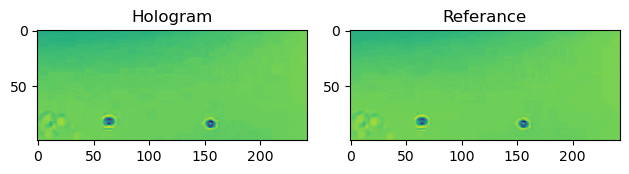

In [123]:
img = img[736:835,550:793]
ref = ref[736:835,550:793]

# Display result
def DisplayImg(img,ref):
    #img = img[46:846, 1350:2150]
    #ref = ref[46:846, 1350:2150]
    fig, axes = plt.subplots(nrows=1, ncols=2) 
    
    axes[0].imshow(abs(img))
    axes[1].imshow(abs(ref))
    
    plt.tight_layout()
    #plt.imshow(abs(img))
    #plt.imshow(abs(ref))
    
    axes[0].set_title('Hologram')
    axes[1].set_title('Referance')

    plt.savefig('holo.tif')
    plt.show()
DisplayImg(img,ref)



In [100]:
# supression of the DC term
def supress_DC(img,ref):
    imgH = (img - ref) #/ (np.sqrt(ref))

    #imgH = img - np.mean(img)

    # imgH = np.sqrt(image_normalized)
    return imgH
imgH=supress_DC(img,ref)

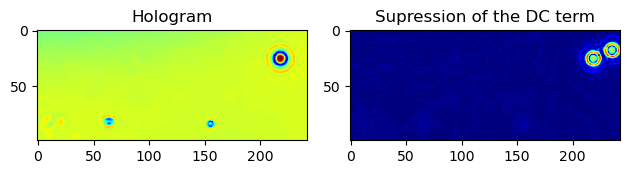

In [101]:
# Create a figure and subplots
def sub_plot(img,imgh):
    fig, axes = plt.subplots(nrows=1, ncols=2) 

    # Display the images on respective subplots
    axes[0].imshow(abs(img), cmap = 'jet')
    axes[1].imshow(abs(imgH), cmap = 'jet')

    # Optionally, you can add titles to each subplot
    axes[0].set_title('Hologram')
    axes[1].set_title('Supression of the DC term')

    # Optionally, you can remove the ticks on the axes if needed
    # axes[0].axis('off')
    # axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    #plt.savefig("subplot_images.png") # To save the plot to a file
sub_plot(img,imgH)

In [46]:
# Set the physical parameters
Ny,Nx = supress_DC(img,ref).shape

Lambda = 530e-9            # wavelength of the light source
k = 2*np.pi/Lambda         # wavenumber
dx = 1.55e-6               # pixel size of the camera in the x-coord
dy = dx
UpsampleFactor = 2

# Define the spatial and frequency/spectral sampling intervals and coords
nx = np.arange((-Nx/2),(Nx/2) , dtype = float)
ny = np.arange((-Ny/2),(Ny/2) , dtype = float)

# Spatial sampling
x = nx*dx
y = ny*dy

X, Y = np.meshgrid(x,y)
# Frequency sampling
dfx = 1/(Nx *dx)
dfy = 1/(Ny *dy)

fx = nx*dfx
fy = ny*dfy
Fx,Fy = np.meshgrid(fx,fy)

In [47]:
# d = 1e-3
#d = (Nx * dx**2) / Lambda
#R = (1/d)*np.exp(-1j*k*d)*np.exp(-1j*np.pi/(Lambda*d)*(X**2 + Y**2))
#plt.imshow(abs(R)**2, cmap='gray')

Text(0.5, 1.0, 'Fourier Spectrum of the sample')

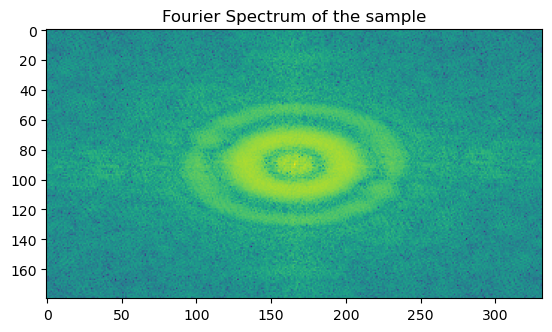

In [48]:
# Perform the Fourier transformation on the processed hologram 
FimgH = fftshift(fft2(imgH))
# FimgH = FimgH - np.mean(FimgH) 

plt.tight_layout()
plt.imshow(np.log(abs(FimgH)))
plt.title('Fourier Spectrum of the sample')

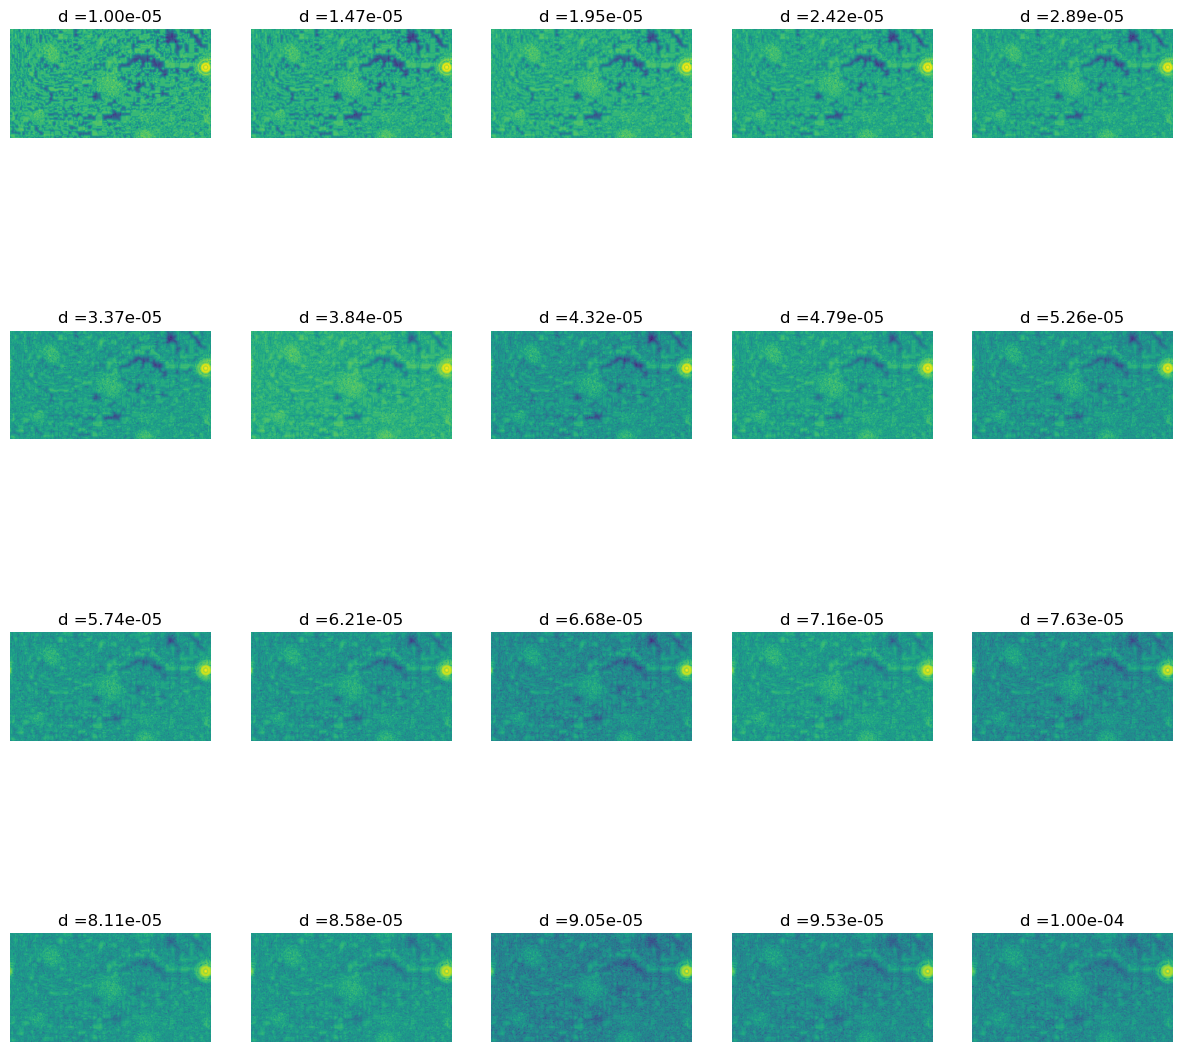

In [49]:
dis=np.linspace(0.1e-4,1e-4,20)

# Propagate to the twin image using the Angular Spectrum Method (ASM)
j=1
plt.figure(figsize=(15,15))

for i in  dis:
    prop = np.exp((1j*2*np.pi*i)*np.sqrt((1/(Lambda**2)) - Fx**2 - Fy**2))
    t = (ifft2(fftshift(FimgH*prop)))
    plt.subplot(4,5,j)
    plt.title(f'd ={i:.2e}')
    plt.axis('off')
    j+=1
    plt.imshow((np.log(abs(t))))

    



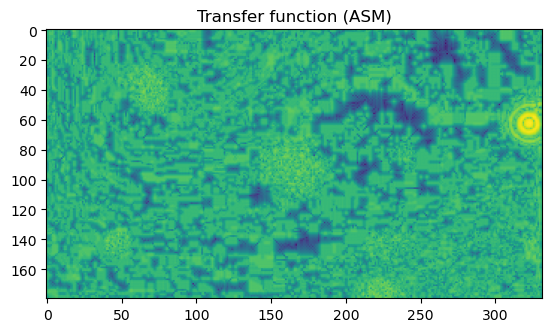

In [50]:
#  trasfer function the wave field

def trasFunc(d):
    prop = np.exp((1j*2*np.pi*d)*np.sqrt((1/(Lambda**2)) - Fx**2 - Fy**2))
    t = (ifft2(fftshift(FimgH*prop)))

    #plt.tight_layout()
    plt.imshow(np.log(abs(t)))
    plt.title('Transfer function (ASM)')

d=1e-5    
trasFunc(d)

(180, 332)


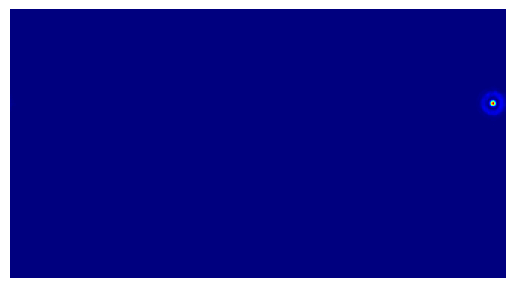

In [51]:
# display results
#%matplotlib tk
amp = (abs(t))                   # amplitude
print(amp.shape)
# Visualize the amplitude
plt.tight_layout()
plt.axis('off')
plt.imshow((abs(amp))**2, cmap='jet')
#plt.colorbar()
#plt.title('amplitude')
#plt.savefig('ampp30.jpeg')

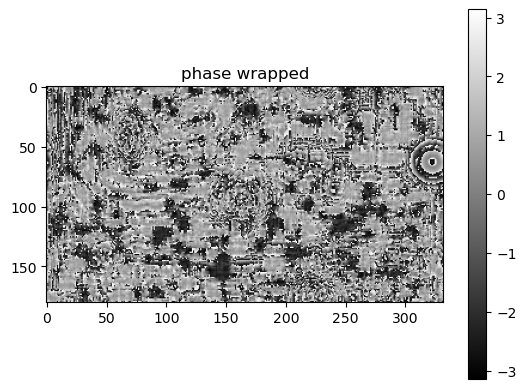

In [52]:
phi = np.angle(t)                   # amplitude

# Visualize the amplitude
plt.tight_layout()
plt.imshow(phi, cmap = 'gray')
plt.colorbar()
plt.title('phase wrapped')
#plt.savefig('phi.tif')
plt.show()

Text(0.5, 1.0, 'unwrapped phase with the twin-image')

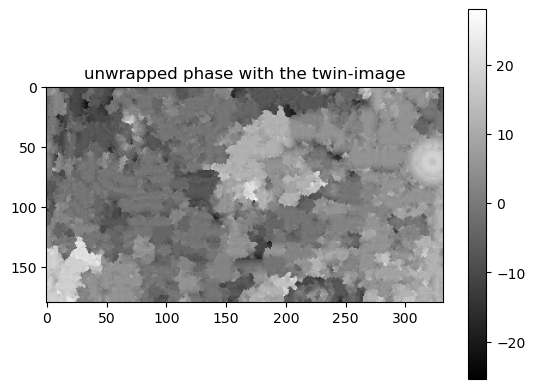

In [53]:
UnimgH = -unwrap_phase(phi)     # unwrapped phase

# Visualize the phase 
plt.tight_layout()
plt.imshow(UnimgH, cmap='gray')
plt.colorbar()
plt.title('unwrapped phase with the twin-image')
#plt.savefig('unwrap phase.tif')

### Segment the twin-image


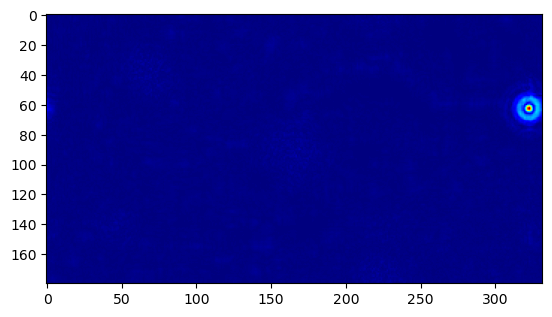

In [54]:
# 
n = 1
R_TI = amp
R_TI_padded = np.hstack([np.vstack([R_TI, np.zeros((n-1,R_TI.shape[1]))]),\
                                          np.zeros((R_TI.shape[0]+n-1,n-1))])
plt.tight_layout()
plt.imshow(R_TI_padded, cmap = 'jet');

In [55]:
R_TI_padded.shape

(180, 332)

1.5458923808806e-05

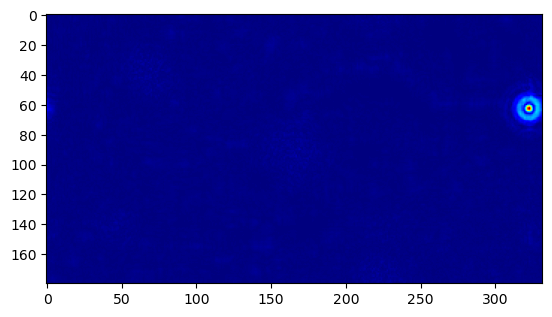

In [56]:
# the averages
mu = np.sum(np.lib.stride_tricks.sliding_window_view(R_TI_padded, (n,n)), axis=(2,3))/n**2

plt.tight_layout()
plt.imshow(mu, cmap = 'jet');

np.min(mu)

In [ ]:
mu.shape

In [ ]:
T = (abs(R_TI)**2 - mu)**2
T_padded = np.hstack([np.vstack([T, np.zeros((n-1,T.shape[1]))]),\
                                    np.zeros((T.shape[0]+n-1,n-1))])

In [ ]:
#T_padded.shape

In [ ]:
V = np.sum(np.lib.stride_tricks.sliding_window_view(T_padded, (n,n)), axis=(2,3))/n**2

plt.tight_layout()
plt.imshow(V, cmap = 'jet');

np.min(V)

In [ ]:
tau = 0.005  # threshold
mask = (V > tau).astype(int)

plt.tight_layout()
plt.imshow(mask, cmap = 'gray');

In [ ]:
R_S = R_TI*mask

plt.tight_layout()
plt.imshow(abs(R_S), cmap = 'jet');

## Propagate to the hologram plane

In [ ]:
z = -d

# Propagate to the twin image using the Angular Spectrum Method (ASM)
#G = np.exp((1j*2*np.pi*z)*np.sqrt(1/(Lambda**2) - Fx**2 - Fy**2))

G = np.exp((1j*2*np.pi*z)*np.sqrt((1/(Lambda**2)) - Fx**2 - Fy**2))

In [ ]:
FimG = fftshift(fft2(R_S))
FimgH = FimgH - np.mean(FimgH) 

plt.tight_layout()
plt.imshow(np.log(abs(FimG)))

In [ ]:
t2 = (ifft2(fftshift(FimG*G)))

plt.tight_layout()
plt.imshow(np.log(abs(t2)))

In [ ]:
# display results
amp2 = (abs(t2))**2 

# Visualize the amplitude
plt.tight_layout()
plt.imshow(amp2, cmap='jet')
plt.colorbar()
#plt.title('amplitude with no twin-image')
plt.savefig('amp.tif')

In [ ]:
# wrapped phase 
phi2 = np.angle(t2)              # wrapped phase

# # Visualize the phase 
#plt.tight_layout()
plt.figure(figsize=(8,5))
plt.imshow(phi2, cmap = 'jet')
plt.colorbar()
plt.title('wrapped phase with no twin-image')


In [ ]:
np.all(phi2 >= -np.pi) and np.all(phi2 <= np.pi)

In [ ]:
# # Visualize the phase 
UnimgH2 = unwrap_phase(phi2)     # unwrapped phase

#plt.tight_layout()
plt.figure(figsize=(8,5))
plt.imshow(UnimgH2, cmap = 'jet')
plt.colorbar()
#plt.title('wrapped phase with no twin-image')
# plt.savefig('phi.tif') # To save the plot to a file

In [ ]:
# # Thickness calculation

wavelength = 0.488
ri_bead = 1.430
ri_med = 1.510
ref_index_diff = abs(ri_bead - ri_med)
factor = wavelength / (2 * np.pi * ref_index_diff)
thickness = factor * UnimgH2

# Plotting the thickness as a mesh plot
fig = plt.figure(8)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(0, thickness.shape[1], 1)
Y = np.arange(0, thickness.shape[0], 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, thickness, cmap='jet')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Thickness')
ax.set_title('Thickness Mesh Plot')
plt.savefig('3D.tif')
plt.show()

In [ ]:
UnimgH2 = phase_unwrap(phi2)     # unwrapped phase

#plt.tight_layout()
plt.figure(figsize=(8,5))
plt.imshow(UnimgH2, cmap = 'jet')
plt.colorbar()
#plt.title('wrapped phase with no twin-image')
# plt.savefig('phi.tif') # To save the plot to a file

In [ ]:
# # Thickness calculation

wavelength = 0.488
ri_bead = 1.430
ri_med = 1.510
ref_index_diff = abs(ri_bead - ri_med)
factor = wavelength / (2 * np.pi * ref_index_diff)
thickness = factor * UnimgH2

# Plotting the thickness as a mesh plot
fig = plt.figure(8)
ax = fig.add_subplot(111, projection='3d')
X = np.arange(0, thickness.shape[1], 1)
Y = np.arange(0, thickness.shape[0], 1)
X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, thickness, cmap='jet')
#ax.set_xlabel('X')
#ax.set_ylabel('Y')
#ax.set_zlabel('Thickness')
ax.set_title('Thickness Mesh Plot')
plt.savefig('3D.tif')
plt.show()

In [ ]:
import numpy as np
from scipy.fftpack import dct, idct

def unwrap_TIE(phase_wrap):
    psi = np.exp(1j * phase_wrap)
    edx = np.hstack([np.zeros([psi.shape[0], 1]), np.unwrap(np.angle(np.diff(psi, axis=1)), axis=1), np.zeros([psi.shape[0], 1])])
    edy = np.vstack([np.zeros([1, psi.shape[1]]), np.unwrap(np.angle(np.diff(psi, axis=0)), axis=0), np.zeros([1, psi.shape[1]])])
    lap = np.diff(edx, axis=1) + np.diff(edy, axis=0)
    rho = np.imag(np.conj(psi) * lap)
    return solvePoisson(rho)

def solvePoisson(rho):
    # solve the poisson equation using DCT
    dctRho = dct(dct(rho.T, norm='ortho').T, norm='ortho')
    N, M = rho.shape
    I, J = np.meshgrid(np.arange(M), np.arange(N))
    dctPhi = dctRho / 2 / (np.cos(np.pi*I/M) + np.cos(np.pi*J/N) - 2)
    dctPhi[0, 0] = 0 # handling the inf/nan value
    # now invert to get the result
    phi = idct(idct(dctPhi.T, norm='ortho').T, norm='ortho')
    return phi

def Unwrap_TIE_DCT_Iter(phase_wrap):
    phi1 = unwrap_TIE(phase_wrap)
    phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
    K1 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
    phase_unwrap = phase_wrap + 2 * K1 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
    phi1 += unwrap_TIE(residue)
    phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
    K2 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
    phase_unwrap = phase_wrap + 2 * K2 * np.pi
    residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
    N = 0
    c = 0
    while np.sum(np.abs(K2 - K1)) > 0 and c < 2:
        K1 = K2
        phic = unwrap_TIE(residue)
        phi1 += phic
        phi1 += np.mean(phase_wrap) - np.mean(phi1) # adjust piston
        K2 = np.round((phi1 - phase_wrap) / 2 / np.pi) # calculate integer K
        phase_unwrap = phase_wrap + 2 * K2 * np.pi
        residue = np.angle(np.exp(1j * phase_unwrap) / np.exp(1j * phi1))
        N += 1
        c += 1
    return phase_unwrap, N

In [ ]:
UnimgH3 = unwrap_TIE(phi2)     # unwrapped phase

#plt.tight_layout()
#plt.figure(figsize=(6,5))
plt.imshow(UnimgH3, cmap = 'jet')
plt.colorbar()
#plt.title('wrapped phase with no twin-image')
# plt.savefig('phi.tif') # To save the plot to a file

FileNotFoundError: [Errno 2] No such file or directory: 'ampp11.tif'

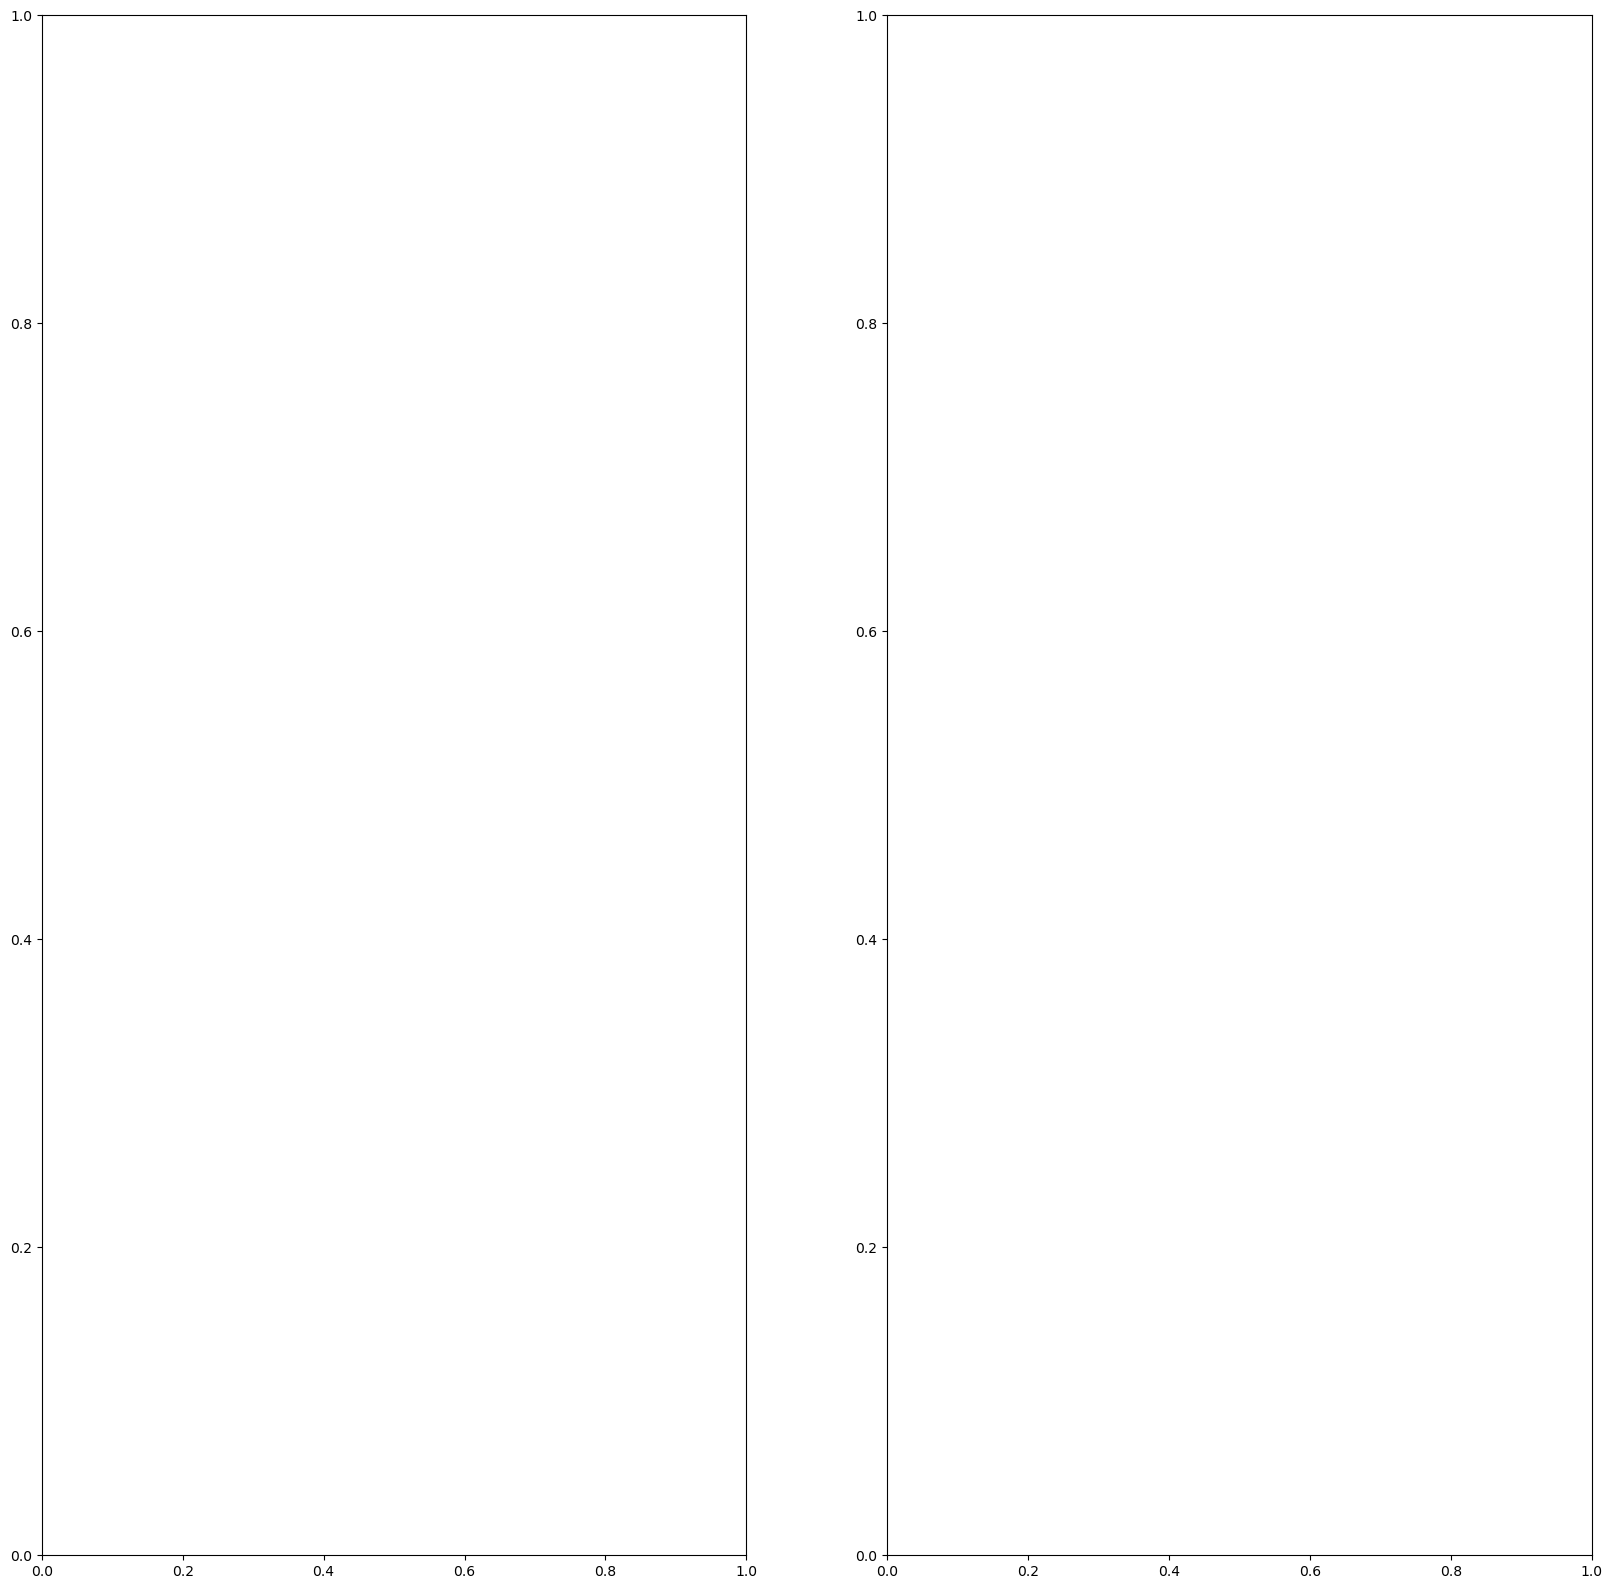

In [70]:
fig, axes = plt.subplots(figsize=(20,20),nrows=1, ncols=2) 
img_img=Image.open('ampp11.tif')
img_vid=Image.open('ampp15.tif')
# Display the images on respective subplots
axes[0].imshow(img_img)
axes[1].imshow(img_vid)

# # Optionally, you can add titles to each subplot
axes[0].set_title('IMG')
axes[1].set_title('VID')


# Optionally, you can remove the ticks on the axes if needed
axes[0].axis('off')
axes[1].axis('off')

#plt.tight_layout()
#plt.figure(figsize=(50,50))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Read the image
def image_profile(image):
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)[28:426,300:467]

    # Select the row for the image profile
    row_index = 150

    # Get the intensity values along the row
    intensity_values = image[row_index, :]

    # Create the x-axis values (pixel indices)
    x_values = np.arange(len(intensity_values))

    # Plot the image profile
    plt.plot(x_values, intensity_values)
    plt.xlabel('Pixel Index')
    plt.ylabel('Intensity')
    plt.title('Image Profile along Row')
    plt.show()


In [ ]:
image_profile('ampp15.tif')


In [ ]:
image_profile('ampp.tif')

In [71]:
image = cv2.imread('ampp1.tif', cv2.IMREAD_GRAYSCALE)[60:424,110:476]

NameError: name 'cv2' is not defined

In [72]:
cv2.imwrite('saved_image1.jpg', image)

NameError: name 'cv2' is not defined

In [73]:


image = cv2.imread('ampp.tif', cv2.IMREAD_GRAYSCALE)[60:424,110:476]
cv2.imwrite('saved_image.jpg', image)


NameError: name 'cv2' is not defined

In [74]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def multi_image_profile(images, row,file_name):
    
    fig,ax=plt.subplots()
    for i,image in enumerate(images):
        image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)[28:426,300:467]

        # Get the intensity values along the row
        intensity_values = image[row, :]

        # Create the x-axis values (pixel indices)
        x_values = np.arange(len(intensity_values))
        name=images[i].split('.')[0]

        # Plot the image profile
        ax.plot(x_values, intensity_values,label=name)
    ax.set_xlabel('Pixel Index')
    ax.set_ylabel('Intensity')
    ax.set_title('Image Profile along Row')
    ax.legend()
    plt.show()
    fig.savefig(file_name)

TypeError: 'NoneType' object is not subscriptable

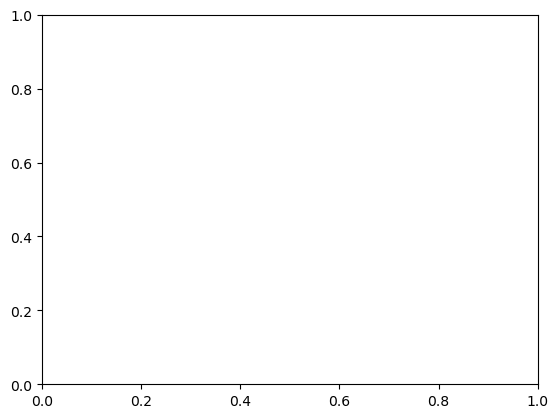

In [98]:
images=['ampp.tif','ampp10.tif','ampp20.tif','ampp30.tif']
multi_image_profile(images, 180,'fpm10_30.png')

In [ ]:
images=['ampp.tif','ampp1.tif','ampp2.tif', 'ampp6.tif','ampp7.tif']
multi_image_profile(images, 180,'fps1_6.png')

TypeError: 'NoneType' object is not subscriptable

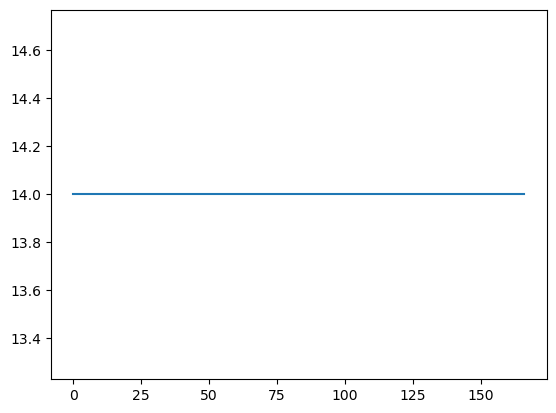

In [99]:
images=['amp.tif','amp1.tif','amp2.tif', 'amp6.tif','amp7.tif']
multi_image_profile(images, 180,'fps1_6_without_twin.png')

FileNotFoundError: [Errno 2] No such file or directory: 'ampp.tif'

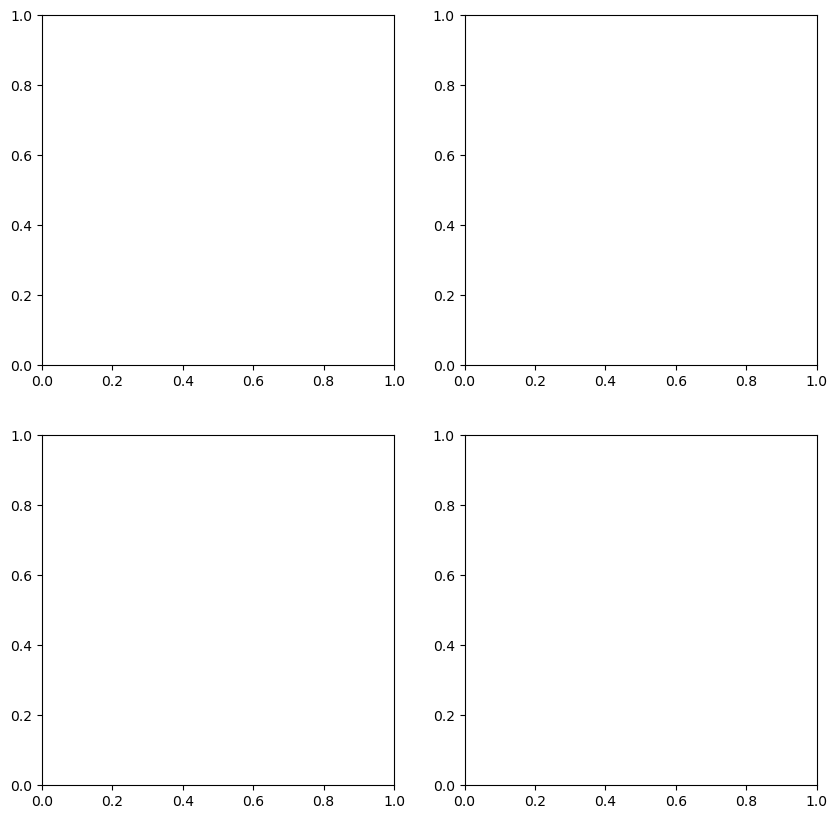

In [100]:
fig,axes=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
#fig.subplots_adjust(hspace=0.005,wspace=0.005)
images=['ampp.tif','ampp1.tif','ampp2.tif', 'ampp3.tif']

for ax,img in zip(axes.flat,images):
    img=Image.open(img)
    ax.imshow(img)
    ax.axis('off')
# # ax=axes.flat
# img_img=Image.open('ampp11.tif')
# axes[0].imshow(img_img)
plt.tight_layout()

plt.show()

In [ ]:
import numpy as np

# Specify the data type
data_type = np.uint8

# Find the bit depth
bit_depth = np.dtype(data_type).itemsize * 8

print(bit_depth)


In [ ]:
import numpy as np
from PIL import Image

# Open the image
image = Image.open("C://Users//kande//OneDrive//Desktop//Particle_trac//06_22_2023(fiber)//img.tif")
#image = Image.open("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//frames_fb2//frame_1.tif")

# Convert the image to a NumPy array
image_array = np.array(image)

# Get the data type of the array
data_type = image_array.dtype

# Find the bit depth based on the data type
bit_depth = data_type.itemsize * 8

print(f"Bit Depth: {bit_depth}")

type(image_array)



In [ ]:
from PIL import Image

# Open the image
image = Image.open("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//frames_fb2//frame_1.tif")

# Get the size of the image
image_size = image.size

print(f"Size of the image: {image_size}")


In [ ]:
import os

# Specify the path to the image file
image_path = "C://Users//kande//OneDrive//Desktop//Particle_trac//06_22_2023(fiber)//img.tif"

# Get the size of the image file
file_size = os.path.getsize(image_path)

print(f"Size of the image file: {file_size} bytes")



In [ ]:
from PIL import Image

def img_pro(image_path):

    # Open the image
    image = Image.open(image_path)

    # Get image format
    image_format = image.format

    # Get image mode
    image_mode = image.mode

    # Get image size (resolution)
    image_size = image.size

    # Get image width and height separately
    image_width = image.width
    image_height = image.height

    # Get image DPI (dots per inch)
    image_dpi = image.info.get('dpi')

    # Print the properties
    print(f"Image Format: {image_format}")
    print(f"Image Mode: {image_mode}")
    print(f"Image Size (Resolution): {image_size}")
    print(f"Image Width: {image_width}")
    print(f"Image Height: {image_height}")
    print(f"Image DPI: {image_dpi}")


In [ ]:
img_pro(image_path)

In [ ]:
new_path="C://Users//kande//OneDrive//Desktop//Particle_trac//frame//frames_fb//frame_1.tif"

img_pro(image_path)

In [ ]:
import os

# Specify the path to the file
file_path = 'path/to/file.ext'

# Get the file size
def get_size(image):
    file_size = os.path.getsize(image)

    print(f"File Size: {file_size} bytes")


In [ ]:
get_size(image_path)

In [ ]:
get_size(new_path)

In [ ]:
im=Image.open(image_path)
matrix=np.array(im)


In [ ]:
matrix_img = np.zeros((im.height, im.width))

matrix_img.shape


In [ ]:
for i in range(im.height):
    for j in range(im.width):
        matrix_img[i][j]=(sum(matrix[i][j])//3)
        

In [ ]:
plt.imshow(matrix_img,cmap='gray') 

In [ ]:
matrix_img 

In [ ]:
im=im.convert('L')
im.show(im)

In [ ]:
dis

In [20]:
import cv2
import numpy as np

# Function to detect colored particles in a frame
def detect_particles(frame):
    # Define the lower and upper bounds of the color you want to track (in BGR format)
    lower_color = np.array([0, 0, 100])
    upper_color = np.array([100, 100, 255])

    # Convert the frame to the HSV color space
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color range
    mask = cv2.inRange(hsv_frame, lower_color, upper_color)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store the particle positions
    particle_positions = []

    for contour in contours:
        # Calculate the centroid of each particle
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            particle_positions.append((cx, cy))

    return particle_positions

# Open the video file (replace 'video.mp4' with your video file)
cap = cv2.VideoCapture("C://Users//kande//OneDrive//Desktop//Particle_trac//09_20_2023//fvid1.h264")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect particles in the current frame
    particle_positions = detect_particles(frame)

    # Draw circles around the detected particles
    for (cx, cy) in particle_positions:
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)  # Red circles

    # Display the frame with particle positions
    cv2.imshow('Particle Tracking', frame)

    if cv2.waitKey(20) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()


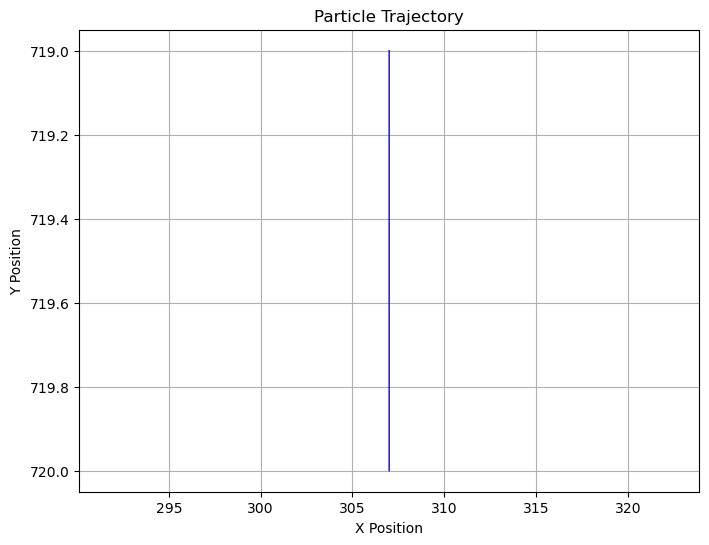

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to detect colored particles in a frame
def detect_particles(frame):
    # Define the lower and upper bounds of the color you want to track (in BGR format)
    lower_color = np.array([0, 0, 100])
    upper_color = np.array([100, 100, 255])

    # Convert the frame to the HSV color space
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Create a mask for the specified color range
    mask = cv2.inRange(hsv_frame, lower_color, upper_color)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store the particle positions
    particle_positions = []

    for contour in contours:
        # Calculate the centroid of each particle
        M = cv2.moments(contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            particle_positions.append((cx, cy))

    return particle_positions

# Open the video file (replace 'video.mp4' with your video file)
cap = cv2.VideoCapture("C://Users//kande//OneDrive//Desktop//Particle_trac//09_20_2023//fvid1.h264")

# Lists to store particle positions over time
particle_trajectory_x = []
particle_trajectory_y = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect particles in the current frame
    particle_positions = detect_particles(frame)

    # Draw circles around the detected particles and update the trajectory
    for (cx, cy) in particle_positions:
        cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)  # Red circles
        particle_trajectory_x.append(cx)
        particle_trajectory_y.append(cy)

    # Display the frame with particle positions
    cv2.imshow('Particle Tracking', frame)

    if cv2.waitKey(20) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()

# Plot the trajectory
plt.figure(figsize=(8, 6))
plt.plot(particle_trajectory_x, particle_trajectory_y, 'b-', linewidth=1)
plt.title('Particle Trajectory')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.gca().invert_yaxis()  # Invert the Y-axis to match typical coordinate systems
plt.grid(True)
plt.show()


In [38]:
import cv2
import numpy as np

# Define the color range you want to track (in BGR format)
lower_color = np.array([0, 0, 100])  # Lower bound (replace with your desired values)
upper_color = np.array([100, 100, 255])  # Upper bound (replace with your desired values)

# Initialize variables for tracking
found = False
x, y = 0, 0

# Open the camera (you can also load a video file)
cap = cv2.VideoCapture("C://Users//kande//OneDrive//Desktop//Particle_trac//09_20_2023//fvid1.h264")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Create a mask for the specified color range
    mask = cv2.inRange(frame, lower_color, upper_color)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store the centroid of the tracked object
    cx, cy = 0, 0

    # Check if any contours were found
    if contours:
        # Find the largest contour (assuming it's the object you want to track)
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get the centroid of the largest contour
        M = cv2.moments(largest_contour)
        if M["m00"] > 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            found = True

    # Display the frame with the tracked object
    if found:
        cv2.circle(frame, (cx, cy), 1, (0, 0, .5), -1)  # Draw a red circle at the centroid
        x, y = cx, cy  # Update the object's position
        found = False  # Reset the found flag if needed

    cv2.imshow('Color Tracking', frame)

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cap.release()
cv2.destroyAllWindows()


In [109]:
path="C://Users//kande//OneDrive//Desktop//Particle_trac//frame//09_20_2023//"
img,ref=load_img(path)
#img=(img>.72)
#plt.imshow(img, cmap='jet')

#img.shape

In [117]:
#%matplotlib inline # for inline image display inside notebook
from PIL import Image
from skimage.io import imread, imshow, show
import scipy.fftpack as fp
from scipy import ndimage, misc, signal
#from scipy.stats import signaltonoise
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.transform import rescale
import matplotlib.pylab as pylab
import numpy as np
import numpy.fft
import timeit

face_image =img-img.mean() #misc.face(gray=True) - misc.face(gray=True).mean()
template_image = np.copy(face_image[516:550, 930:960]) # right eye
template_image -= template_image.mean()
#face_image = face_image + np.random.randn(*face_image.shape) * 50 # add
#random noise
correlation = signal.correlate2d(face_image, template_image,
boundary='symm', mode='same')
y, x = np.unravel_index(np.argmax(correlation), correlation.shape) # findthe match
fig, (ax_original, ax_template, ax_correlation) = pylab.subplots(3, 1,
figsize=(6, 15))
ax_original.imshow(face_image, cmap='gray')
ax_original.set_title('Original', size=20)
ax_original.set_axis_off()
ax_template.imshow(template_image, cmap='gray')
ax_template.set_title('Template', size=20)
ax_template.set_axis_off()
ax_correlation.imshow(correlation, cmap='afmhot')
ax_correlation.set_title('Cross-correlation', size=20)
ax_correlation.set_axis_off()
ax_original.plot(x, y, 'ro')
fig.show()
print(y,x)

934 398


In [87]:
%matplotlib tk
face_image =img-img.mean()

plt.imshow(face_image, cmap='gray')

In [432]:
# for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')
     

In [433]:
# To read standard files, including tiff stacks, we can use pims.open
@pims.pipeline
def gray(image):
    return np.invert(image[:, :, 1])
my_fl_img=gray(pims.open("C://Users//kande//OneDrive//Desktop//Particle_trac//frame//New folder//*.tif"))

In [434]:
my_fl_img

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: C:\Users\kande\OneDrive\Desktop\Particle_trac\frame\New folder\*.tif
    Length: 451 frames
    Frame Shape: (990, 1332, 3)
    Pixel Datatype: uint8

In [435]:
#!pip install stardist

In [436]:
from stardist.models import StarDist2D 
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [437]:
# prints a list of available models 

StarDist2D.from_pretrained() 

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [438]:
model = StarDist2D.from_pretrained('2D_demo')

Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


(-0.5, 1331.5, 989.5, -0.5)

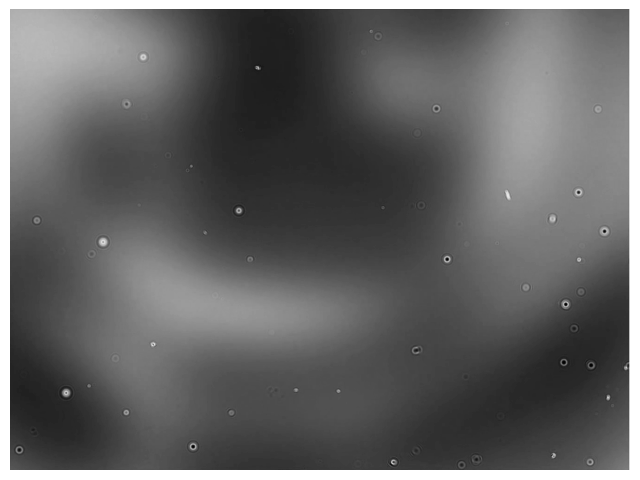

In [439]:
plt.figure(figsize=(8,8))


plt.imshow(my_fl_img[10],cmap="gray")
plt.axis("off")

In [440]:
@pims.pipeline
def stardist_segm(img):
  img_labels, img_details = model.predict_instances(normalize(img))
  return img_labels

In [441]:
label_image = stardist_segm(my_fl_img)

In [442]:
label_image

(Pipeline,) processed through proc_func. Original repr:
    (ImageSequence,) processed through proc_func. Original repr:
        <Frames>
        Source: C:\Users\kande\OneDrive\Desktop\Particle_trac\frame\New folder\*.tif
        Length: 451 frames
        Frame Shape: (990, 1332, 3)
        Pixel Datatype: uint8

Text(0.5, 1.0, 'prediction + input overlay')

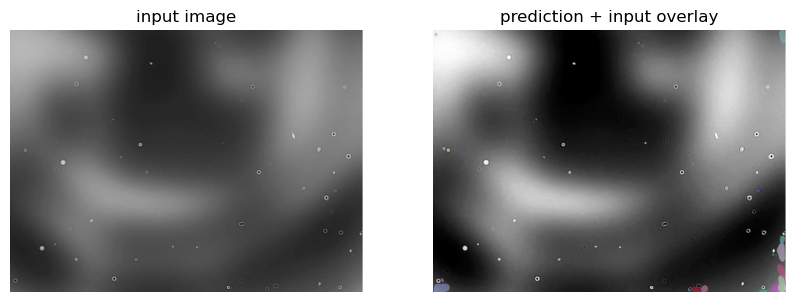

In [443]:
img_num = 10
plt.subplot(1,2,1)
plt.imshow(my_fl_img[img_num], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(label_image[img_num], img=my_fl_img[img_num]))
plt.axis("off")
plt.title("prediction + input overlay")

In [445]:
import skimage

In [444]:
features = pd.DataFrame()
for num, img in enumerate(my_fl_img):
    for region in skimage.measure.regionprops(label_image[num], intensity_image=img):
        # Store features 
        features = features.append([{'y': region.centroid[0],
                                     'x': region.centroid[1],
                                     'frame': num,
                                     },])

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
2088870693.py (5): The frame.append metho

In [449]:
features.head

<bound method NDFrame.head of              y            x  frame
0   818.070769   140.200000      0
0   958.506024  1168.277108      0
0   833.060000  1284.910000      0
0   600.993151  1251.582192      0
0   770.343284  1322.104478      0
..         ...          ...    ...
0   820.000000   705.432432    450
0   479.800000   418.911111    450
0   980.888331  1168.964868    450
0   265.890244  1004.207317    450
0   887.069940  1317.708333    450

[20607 rows x 3 columns]>

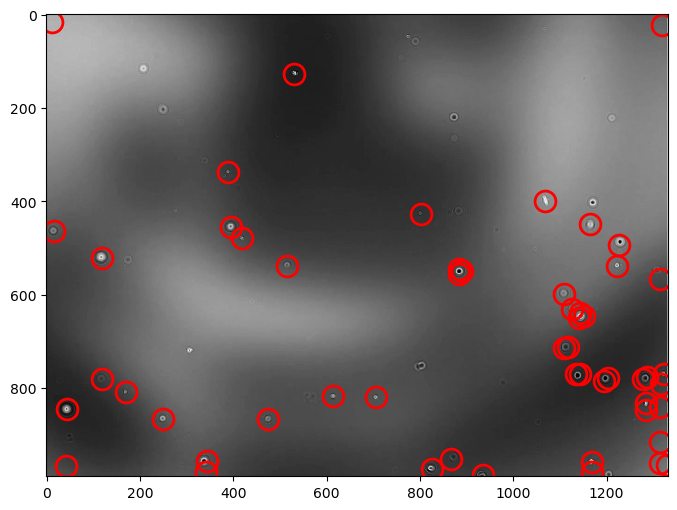

<Axes: >

In [450]:
tp.annotate(features[features.frame==(50)], my_fl_img[50])

In [471]:
# #Plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not required in our case.  
# fig, ax = plt.subplots()
# ax.hist(features['area'], bins=20)

# # Optionally, label the axes.
# ax.set(xlabel='area', ylabel='count');

In [451]:
#Bubble tracking
# we must must specify a maximum displacement, the farthest a object can travel between frames (search_range)
# We allow for the possibility that an object might be missed for a few frames and then seen again. 
# Memory keeps track of disappeared objects and maintains their ID for up to some number of frames after their last appearance. 
# Here we use 5 frames.
#Note that the term particle refers to an object of interest. 
search_range = 5
t = tp.link_df(features, search_range, memory=3)
t.head(80)

Frame 450: 47 trajectories present.


y            x  frame  particle
0   818.070769   140.200000      0         0
0   975.744110  1008.404549      0         1
0   472.612500  1295.900000      0         2
0    16.989474    10.631579      0         3
0   818.023810   613.904762      0         4
..         ...          ...    ...       ...
0   942.720000    37.080000      1        28
0   682.260274  1229.589041      1        15
0   981.852405  1168.723051      1        18
0   974.251071    48.833762      1        63
0   915.344191  1314.252986      1        64

[80 rows x 4 columns]

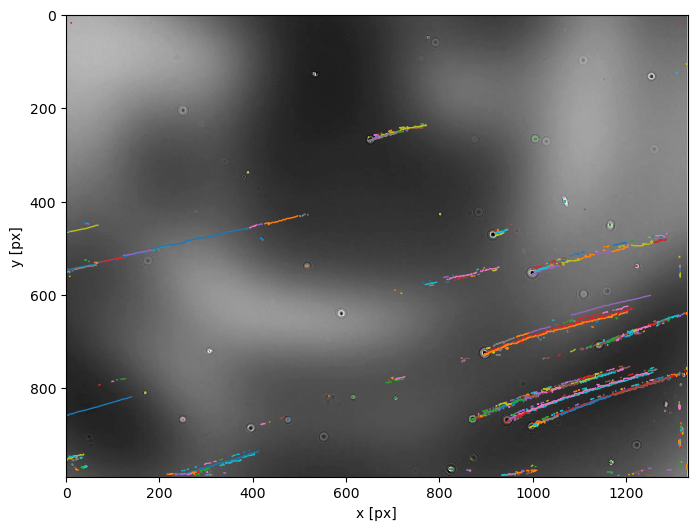

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [452]:
#Plot trajectories
tp.plot_traj(t, superimpose=img) #Remove the superimpose part to just plot the trajectories. 

In [453]:
drift = tp.compute_drift(t)

In [470]:
# drift.plot()
# plt.show()

In [455]:
t_corrected = tp.subtract_drift(t.copy(), drift)

<Figure size 1332x990 with 0 Axes>

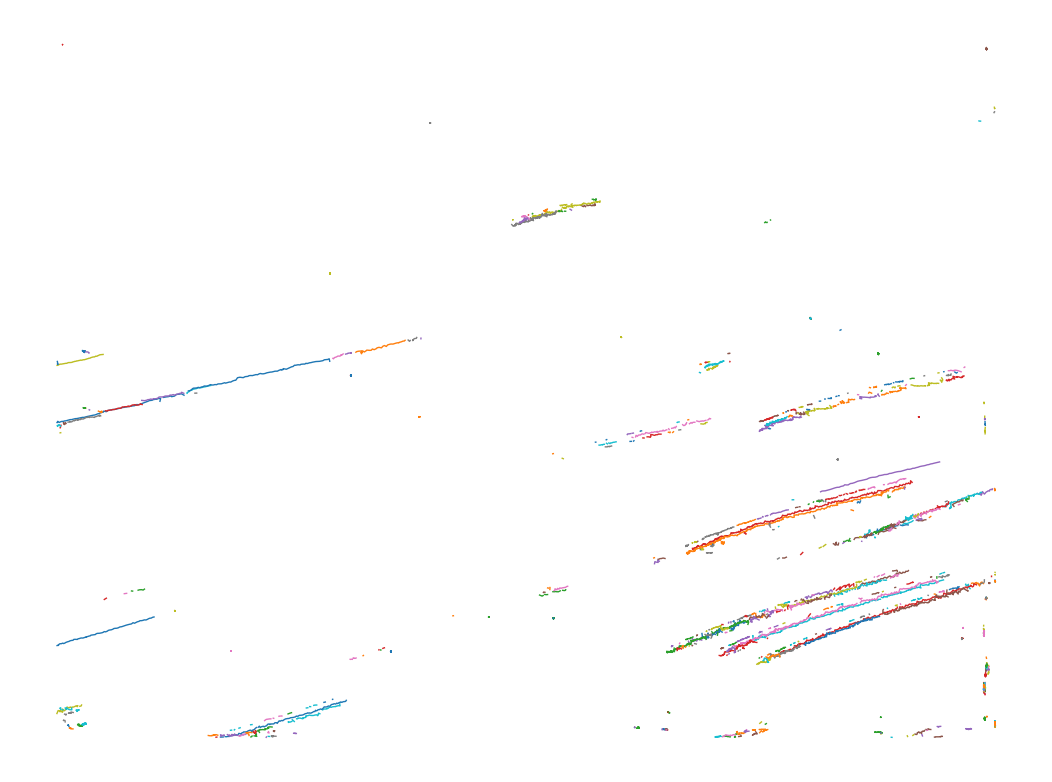

In [521]:

plt.figure(figsize=(1332 / 100, 990 / 100))

fig, ax = plt.subplots(figsize=(1332 / 100, 990 / 100))


plt.axis('off')
tp.plot_traj(t,ax=ax)
plt.savefig('overlay.tif',dpi=100, transparent=True)
plt.show()

In [457]:
unstacked = t.set_index(['frame', 'particle']).unstack()

In [458]:
unstacked

y                                                          \
particle         0           1         2          3           4          5     
frame                                                                          
0         818.070769  975.744110  472.6125  16.989474  818.023810  22.918947   
1         818.530864  976.965347       NaN  16.950980  818.023810  22.293660   
2         819.612500  976.328792       NaN  16.576577  818.023810  22.785867   
3         819.894410  976.289720       NaN  16.350877  818.073171  22.844587   
4         820.590476  977.325831       NaN  16.350877  818.073171  22.723176   
...              ...         ...       ...        ...         ...        ...   
446              NaN         NaN       NaN  16.464286         NaN  22.538793   
447              NaN         NaN       NaN  16.464286         NaN  22.648765   
448              NaN         NaN       NaN  16.464286         NaN  22.674493   
449              NaN         NaN       NaN  16.464286         NaN  22.400876   
450              NaN         NaN       NaN  16.464286         NaN  22.498920   

                                                          ...           x      \
particle         6           7           8           9    ...         811 812   
frame                                                     ...                   
0         468.122222  965.521739  839.035000  755.757576  ...         NaN NaN   
1         468.704545  965.295775  839.187186  756.333333  ...         NaN NaN   
2                NaN  965.428571  838.916976         NaN  ...         NaN NaN   
3                NaN  965.573529  839.284483         NaN  ...         NaN NaN   
4                NaN  965.031250  839.431175  757.111111  ...         NaN NaN   
...              ...         ...         ...         ...  ...         ...  ..   
446              NaN         NaN         NaN         NaN  ...  912.702128 NaN   
447              NaN         NaN         NaN         NaN  ...  912.652174 NaN   
448              NaN         NaN         NaN         NaN  ...         NaN NaN   
449              NaN         NaN         NaN         NaN  ...         NaN NaN   
450              NaN         NaN         NaN         NaN  ...         NaN NaN   

                                                                       \
particle 813          814    815         816          817         818   
frame                                                                   
0        NaN          NaN    NaN         NaN          NaN         NaN   
1        NaN          NaN    NaN         NaN          NaN         NaN   
2        NaN          NaN    NaN         NaN          NaN         NaN   
3        NaN          NaN    NaN         NaN          NaN         NaN   
4        NaN          NaN    NaN         NaN          NaN         NaN   
...       ..          ...    ...         ...          ...         ...   
446      NaN  1141.774194    NaN         NaN          NaN         NaN   
447      NaN          NaN    NaN         NaN  1168.451372  647.909091   
448      NaN          NaN  867.5  864.396114          NaN  647.857143   
449      NaN  1141.421053    NaN         NaN  1168.592453  647.909091   
450      NaN  1141.542857    NaN         NaN  1168.964868         NaN   

                                  
particle         819         820  
frame                             
0                NaN         NaN  
1                NaN         NaN  
2                NaN         NaN  
3                NaN         NaN  
4                NaN         NaN  
...              ...         ...  
446              NaN         NaN  
447              NaN         NaN  
448              NaN         NaN  
449       913.219178         NaN  
450       911.927273  939.882353  

[451 rows x 1642 columns]

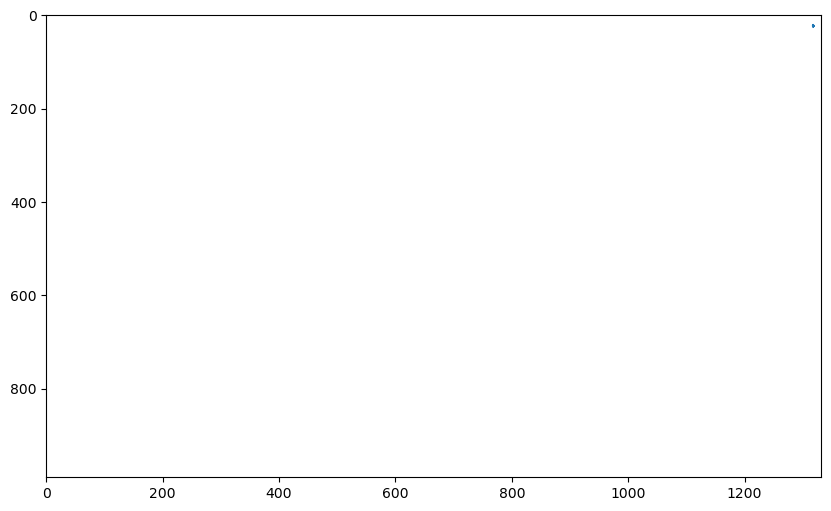

In [469]:
plt.plot((unstacked.iloc[:].x)[5],(unstacked.iloc[:].y)[5])
plt.xlim(0,1332)
plt.ylim(0,990)
plt.gca().invert_yaxis()


In [421]:
((unstacked.iloc[:].y)[3])[150]

848.3176470588236

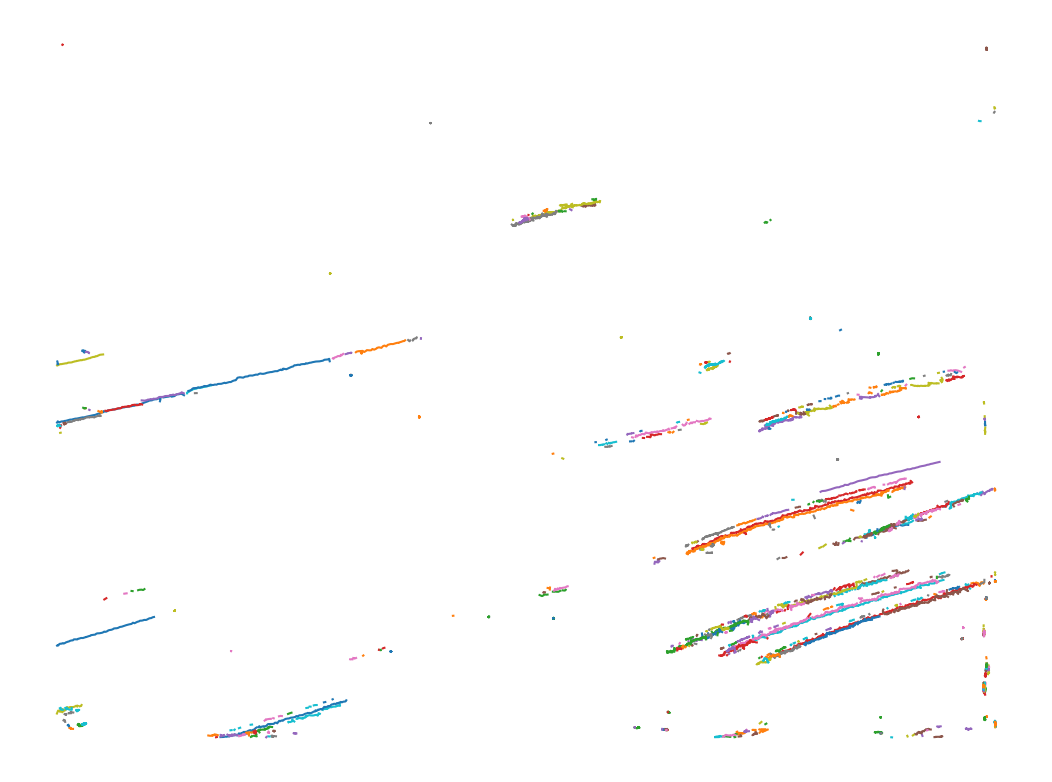

In [512]:
#plt.plot((unstacked.iloc[:].x),(unstacked.iloc[:].y))
# plt.xlim(0,1332)
# plt.ylim(0,990)
plt.figure(figsize=(1332 / 100, 990 / 100))
plt.plot((unstacked.iloc[:].x),(unstacked.iloc[:].y))
plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig('overlay.tif',transparent=True,dpi=100)
plt.show()


In [522]:
import cv2
import numpy as np



# Load the video
video_path = "C://Users//kande//OneDrive//Desktop//Particle_trac//python_files//output_video.mp4"
cap = cv2.VideoCapture(video_path)

# Load the frame (replace 'frame.png' with the path to your frame image)
frame_path = "C://Users//kande//OneDrive//Desktop//Particle_trac//python_files//overlay.tif"
frame = cv2.imread(frame_path, cv2.IMREAD_UNCHANGED)

# Get the dimensions of the frame image
frame_height, frame_width, _ = frame.shape

# Define the codec and create a VideoWriter object to save the output video
output_path = 'output_movie.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_size = (int(cap.get(3)), int(cap.get(4)))
out = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

while True:
    ret, frame_video = cap.read()

    if not ret:
        break

    # Resize the frame image to match the video frame size
    frame_resized = cv2.resize(frame, (frame_video.shape[1], frame_video.shape[0]))

    # Extract the alpha channel from the frame
    alpha_channel = frame[:, :, 3] / 255.0

    # Overlay the transparent frame on the video
    for c in range(0, 3):
        frame_video[:, :, c] = (1.0 - alpha_channel) * frame_video[:, :, c] + alpha_channel * frame_resized[:, :, c]

    # Write the frame to the output video
    out.write(frame_video)

    # Display the resulting frame
    cv2.imshow('Video with Overlay', frame_video)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
out.release()

# Close all OpenCV windows
cv2.destroyAllWindows()


In [526]:
f = tp.locate(my_fl_img[0], 11, invert=True)


In [527]:
f.head

<bound method NDFrame.head of                y            x        mass      size       ecc     signal  \
0       5.027211   157.564626   69.596082  2.984085  0.284073   2.367214   
1       5.329114   250.746835   74.803952  2.742077  0.095883   2.840656   
2       6.107143   282.450000   66.281983  2.833473  0.191808   2.367214   
3       5.871212   854.242424   62.494441  3.103029  0.412879   1.893771   
4       5.102804   977.130841   50.658373  2.773371  0.207316   2.367214   
...          ...          ...         ...       ...       ...        ...   
2828  983.637255   162.352941   48.291159  2.816269  0.170420   1.893771   
2829  983.806452   401.021505   88.060349  2.923762  0.195432   2.840656   
2830  980.818966  1019.000000   54.919357  3.366928  0.182014   1.893771   
2831  984.560890  1142.837237  404.320095  2.930099  0.508637  15.623610   
2832  983.932961  1205.128492   84.746250  3.201780  0.265928   2.367214   

      raw_mass        ep  frame  
0       7920.0 -0.07944

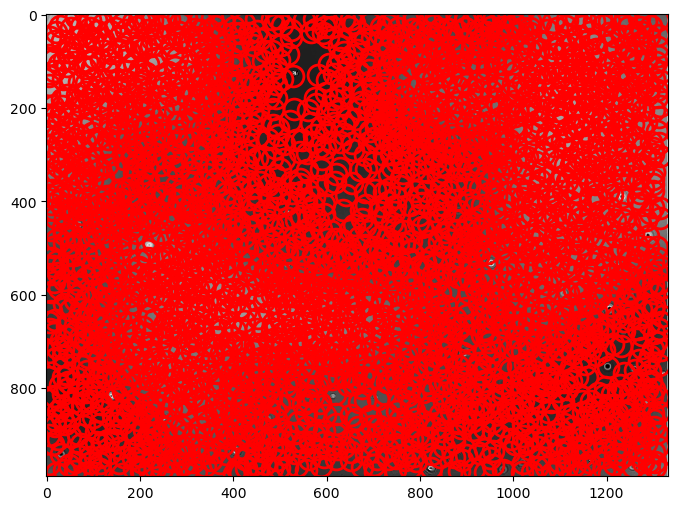

<Axes: >

In [538]:
tp.annotate(f, my_fl_img[0])

In [586]:
f = tp.batch(my_fl_img[:30], 11, minmass=20, invert=True);

Frame 29: 2717 features


In [588]:
t = tp.link(f, 5, memory=3)

Frame 29: 2717 trajectories present.


In [611]:
t1 = tp.filter_stubs(t, 10)
#t1.head

In [612]:
t2 = t1[((t1['mass'] > 30) & (t1['size'] < 2.5 )  &
         (t1['ecc'] < 0.2))]

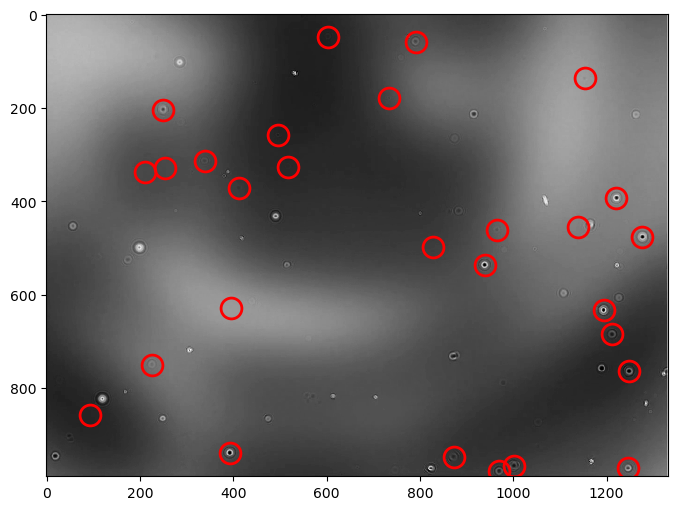

In [613]:
plt.figure()
tp.annotate(t2[t2['frame'] == 10], my_fl_img[10]);

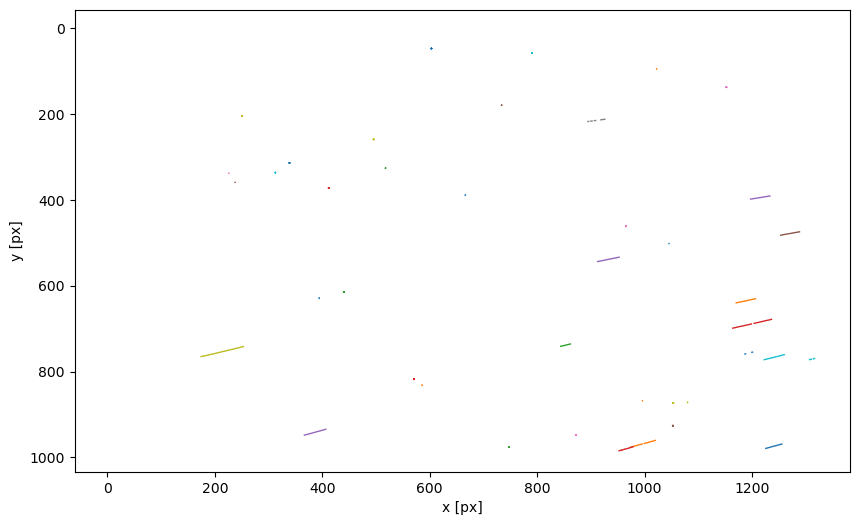

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [614]:
plt.figure()
tp.plot_traj(t2)